#### Imports section

In [1]:
import glob
from collections import Counter
import numpy as np
from scipy.stats import mannwhitneyu, bootstrap
import requests
import pandas as pd
from chardet.universaldetector import UniversalDetector

#### Let's determine the encoding of our file as the default seems to fail

In [2]:
detector = UniversalDetector()
for filename in glob.glob('*.csv'):
    print(filename.ljust(60), end='')
    detector.reset()
    for line in open(filename, 'rb'):
        detector.feed(line)
        if detector.done: break
    detector.close()
    print(detector.result)

kinopoisk rating.csv                                        {'encoding': 'windows-1251', 'confidence': 0.8987821655585254, 'language': 'Russian'}


#### Now we can look into what we have

In [3]:
data = pd.read_csv("kinopoisk rating.csv", encoding='windows-1251', delimiter=";")
data.head()

,num,name_rus,rating_new,origin,genre,rating_old,qty_views
0,1,Зеленая миля,9.1,США,фэнтези/ драма,8.9,692418
1,2,Побег из Шоушенка,9.1,США,драма,8.9,784326
2,3,Властелин колец: Возвращение короля,8.6,Новая Зеландия/ США,фэнтези/ приключения,8.8,481829
3,4,Властелин колец: Две крепости,8.6,Новая Зеландия/ США,фэнтези/ приключения,8.8,467607
4,5,Властелин колец: Братство Кольца,8.6,Новая Зеландия/ США,фэнтези/ приключения,8.8,516856


#### We are intrested only in descriptives of a ratings. According to our deviation stat seems that new rating is more widely spread. However, mean itself is almost the same

In [4]:
data.describe()

,num,rating_new,rating_old,qty_views
count,250.000000,250.000000,250.000000,2.500000e+02
mean,125.500000,8.184400,8.179600,2.893783e+05
std,72.312977,0.272643,0.193114,1.868284e+05
min,1.000000,7.600000,8.000000,2.005600e+04
25%,63.250000,8.000000,8.000000,1.450212e+05
50%,125.500000,8.100000,8.100000,2.516295e+05
75%,187.750000,8.300000,8.300000,4.053790e+05
max,250.000000,9.100000,8.900000,1.303016e+06


#### This indeed can be visualized

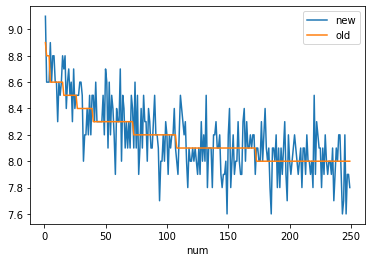

In [5]:
df = pd.DataFrame({'new': data["rating_new"], 'old': data["rating_old"]}, index = data["num"])
lines = df.plot.line()

##### I had a thought that ratings_old looks like rolling average of rating_new, but this is not really the case

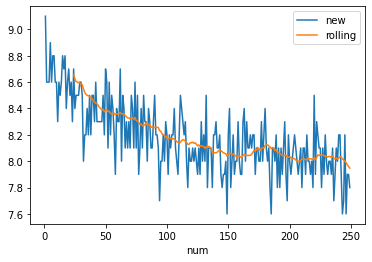

In [6]:
data["rolling_new"] = data["rating_new"].rolling(25).mean()

df = pd.DataFrame({'new': data["rating_new"], 'rolling': data["rolling_new"]}, index = data["num"])
lines = df.plot.line()

#### According to the Mann–Whitney U test the probability of the test statistic exceeds 5%, so we do not consider the results statistically significant. Thus we can't reject the null hypothesis and the distributions of both ratings are identical

In [7]:
mannwhitneyu(data["rating_new"].values, data["rating_old"].values)

MannwhitneyuResult(statistic=31175.5, pvalue=0.9629567921262221)

In [8]:
rng = np.random.default_rng()
res = bootstrap((data["rating_new"].values,), np.mean, confidence_level=0.95, random_state=rng)
print(res.confidence_interval)

ConfidenceInterval(low=8.151099610793699, high=8.2188)


In [9]:
rng = np.random.default_rng()
res = bootstrap((data["rating_old"].values,), np.mean, confidence_level=0.95, random_state=rng)
print(res.confidence_interval)

ConfidenceInterval(low=8.1564, high=8.2048)


#### According to the bootstraping can be 95% confident that true deviation of our sample lies from 0.25 to 0.3 for new ratings and from 0.17 to 0.22 for old. This intervals are not intersecting each other

In [10]:
rng = np.random.default_rng()
res = bootstrap((data["rating_new"].values,), np.std, confidence_level=0.95, random_state=rng)
print(res.confidence_interval)

ConfidenceInterval(low=0.24920636678392163, high=0.30063533871445536)


In [11]:
rng = np.random.default_rng()
res = bootstrap((data["rating_old"].values,), np.std, confidence_level=0.95, random_state=rng)
print(res.confidence_interval)

ConfidenceInterval(low=0.17270367685721122, high=0.21882456951695062)


#### Accorging to our counts we can see that most often country is USA and genre is drama. On average if you are ended up in the top 250 of the Kinopoisk there is no real difference in the mean rating between different groupings. However, in some of them scores are deviating less, than in the others. We can see that Soviet-era films and melodramas are more consistant in ratings on average

In [12]:
countries = data["origin"].apply(lambda x: x.split("/ ")).tolist()
origin = pd.DataFrame.from_dict(Counter(x for xs in countries for x in set(xs)), orient='index').reset_index()
origin.columns = ['Country', 'Count']
origin = origin.sort_values(by=['Count'], ascending=False)
origin["Mean rating_new"] = origin["Country"].apply(lambda x: data[data['origin'].str.contains(x)]["rating_new"].mean())
origin["Standard deviation rating_new"] = origin["Country"].apply(lambda x: data[data['origin'].str.contains(x)]["rating_new"].std())
origin["Mean rating_old"] = origin["Country"].apply(lambda x: data[data['origin'].str.contains(x)]["rating_old"].mean())
origin["Standard deviation rating_old"] = origin["Country"].apply(lambda x: data[data['origin'].str.contains(x)]["rating_old"].std())
origin

,Country,Count,Mean rating_new,Standard deviation rating_new,Mean rating_old,Standard deviation rating_old
0,США,174,8.154598,0.278012,8.178161,0.195277
2,Великобритания,34,8.158824,0.280819,8.167647,0.201089
4,СССР,31,8.377419,0.182043,8.238710,0.183807
9,Германия,15,8.086667,0.247463,8.100000,0.141421
7,Франция,13,8.184615,0.299572,8.130769,0.154837
8,Япония,12,8.133333,0.161433,8.175000,0.171226
3,Канада,8,8.150000,0.267261,8.175000,0.205287
12,Италия,7,8.285714,0.234013,8.085714,0.121499
1,Новая Зеландия,7,8.257143,0.335942,8.400000,0.378594
10,Россия,6,8.083333,0.116905,8.150000,0.164317


In [13]:
genres = data["genre"].apply(lambda x: x.split("/ ")).tolist()
genre = pd.DataFrame.from_dict(Counter(x for xs in genres for x in set(xs)), orient='index').reset_index()
genre.columns = ['Genre', 'Count']
genre = genre.sort_values(by=['Count'], ascending=False)
genre["Mean rating_new"] = genre["Genre"].apply(lambda x: data[data['genre'].str.contains(x)]["rating_new"].mean())
genre["Standard deviation rating_new"] = genre["Genre"].apply(lambda x: data[data['genre'].str.contains(x)]["rating_new"].std())
genre["Mean rating_old"] = genre["Genre"].apply(lambda x: data[data['genre'].str.contains(x)]["rating_old"].mean())
genre["Standard deviation rating_old"] = genre["Genre"].apply(lambda x: data[data['genre'].str.contains(x)]["rating_old"].std())
genre

,Genre,Count,Mean rating_new,Standard deviation rating_new,Mean rating_old,Standard deviation rating_old
1,драма,100,8.224138,0.271107,8.167241,0.189175
5,мультфильм,46,8.121739,0.227950,8.186957,0.184522
4,фантастика,41,8.119512,0.276785,8.185366,0.195654
7,боевик,41,8.075610,0.267190,8.156098,0.165905
3,комедия,40,8.292500,0.302458,8.220000,0.197679
0,фэнтези,38,8.142105,0.278637,8.223684,0.255146
12,мелодрама,29,8.203448,0.193617,8.134483,0.147057
8,криминал,24,8.258333,0.261960,8.183333,0.188049
15,триллер,22,8.172727,0.264002,8.140909,0.159341
2,приключения,21,8.138095,0.304099,8.238095,0.269214


#### The following code can be used to collect data from kinopoisk, however, i was unable to properly use it. For some reasone my best atempt was only 200 rows out of 250, so i used already collected data

import requests
import pandas as pd
from time import sleep
from bs4 import BeautifulSoup

header =['name','name_rus','genre','rating_new','rating_old','views']

data = []

for i in range (1, 6):
    url=f"https://www.kinopoisk.ru/lists/movies/top250/?page={i}"
    r=requests.get(url)
    
    sleep(3)

    soup=BeautifulSoup(r.text, "lxml")
    films=soup.findAll('div',class_='styles_root__ti07r')

    for film in films:
        name=film.find('a',class_='base-movie-main-info_link__YwtP1').find('span', class_='desktop-list-main-info_secondaryText__M_aus').text#.find('span', class_='desktop-list-main-info_secondaryText__M_aus')
        name_rus=film.find('div',class_='styles_content__nT2IG').find('span', class_='styles_mainTitle__IFQyZ styles_activeMovieTittle__kJdJj').text
        genre=film.find('div',class_='styles_content__nT2IG').findAll('span', class_='desktop-list-main-info_truncatedText__IMQRP')[0].text
        rating_new=film.find('div',class_='styles_rating__ni2L0 styles_root___s7Tg styles_rootMd__ZvdRj styles_rootPositive__PIwO2').text
        rating_old=film.find('div',class_='styles_user__2wZvH').find('div',class_='styles_rating__LU3_x').find('span',class_='styles_kinopoiskValuePositive__vOb2E styles_kinopoiskValue__9qXjg').text
        views=film.find('div',class_='styles_user__2wZvH').find('div',class_='styles_rating__LU3_x').find('span',class_='styles_kinopoiskCount__2_VPQ').text

        data.append([name,name_rus,genre,rating_new,rating_old,views])

df = pd.DataFrame(data,columns=header)

df.to_csv("top_250.csv", encoding='windows-1251')

parsedData = pd.read_csv("top_250.xlsx", encoding='windows-1251')
parsedData